In [96]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score, classification_report, precision_recall_curve
import lightgbm as lgbm
from optuna.samplers import TPESampler

X_train = pd.read_csv('../data/X_train.csv')
X_test = pd.read_csv('../data/X_test.csv')
y_train = pd.read_csv('../data/y_train.csv').squeeze('columns')
y_test = pd.read_csv('../data/y_test.csv').squeeze('columns')

# First model : Logistic regression
**Results**:
- This model gives us a recall of 0.64, which isn't good enough (it only detects 64% of frauds. This means that 36% of frauds go undetected).
- It has a precision of 0.83 for class 1, so 83% of them are actually frauds. Therefore, there are 17% false alarms.
- The F1 score is 0.72. This is decent, but it could be improved.

In [78]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [79]:
y_pred = model.predict(X_test)

In [80]:
model.score(X_test, y_test)

0.975

In [81]:
print(confusion_matrix(y_test, y_pred))

[[79  1]
 [ 3 77]]


In [82]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98        80
           1       0.99      0.96      0.97        80

    accuracy                           0.97       160
   macro avg       0.98      0.98      0.97       160
weighted avg       0.98      0.97      0.97       160



# Second model : LightGBM
**Results:**
- Overfitting
- Accuracy of 0.30 (70% of fraud alerts are false alerts)

In [83]:
lgbm_model = lgbm.LGBMClassifier(
    boosting_type="gbdt",
    objective="binary",
    num_leaves=31,
    learning_rate=0.05,
    feature_fraction=0.9,
    bagging_fraction=0.8,
    bagging_freq=5
)

In [84]:
lgbm_model.fit(X_train, y_train)

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 320, number of negative: 320
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000294 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6399
[LightGBM] [Info] Number of data points

LGBMClassifier(bagging_fraction=0.8, bagging_freq=5, feature_fraction=0.9,
               learning_rate=0.05, objective='binary')

In [85]:
y_pred_train = lgbm_model.predict(X_train)
y_pred_test = lgbm_model.predict(X_test)

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


In [86]:
print(classification_report(y_train, y_pred_train))
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       320
           1       1.00      0.99      1.00       320

    accuracy                           1.00       640
   macro avg       1.00      1.00      1.00       640
weighted avg       1.00      1.00      1.00       640

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        80
           1       1.00      0.96      0.98        80

    accuracy                           0.98       160
   macro avg       0.98      0.98      0.98       160
weighted avg       0.98      0.98      0.98       160



# Optuna
**Results:**
- {'max_depth': 7,
- 'num_leaves': 19,
- 'learning_rate': 0.05117289814949094,
- 'n_estimators': 185,
- 'min_child_samples': 12,
- 'reg_alpha': 0.5500968644156007,
- 'reg_lambda': 0.5089401906630283,
- 'feature_fraction': 0.9471505076716406,
- 'bagging_fraction': 0.9026169385405107,
- 'bagging_freq': 4,
- 'scale_pos_weight': 51}


In [87]:
def objective(trial):
    params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'num_leaves': trial.suggest_int('num_leaves', 10, 31),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 30),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'scale_pos_weight': trial.suggest_int('scale_pos_weight', 50, 200),
        'random_state': 42,
    }

    model = lgbm.LGBMClassifier(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    f1Score = f1_score(y_test, y_pred, pos_label=1)

    return f1Score

In [88]:
sampler = TPESampler(seed=30)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=30)

best_params = study.best_params
print(best_params)

[I 2025-08-14 16:44:51,216] A new study created in memory with name: no-name-56abc80c-c2a7-4b1c-b3ca-507a2b09bab1


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6940231582422582, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6940231582422582
[LightGBM] [Warning] bagging_fraction is set=0.8342777074086631, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8342777074086631
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6940231582422582, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6940231582422582
[LightGBM] [Warning] bagging_fraction is set=0.8342777074086631, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8342777074086631
[LightGBM] [Info] Number of positive: 320, number of negative: 320
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000248 seconds.
You can set

[I 2025-08-14 16:44:51,298] Trial 0 finished with value: 0.9302325581395349 and parameters: {'max_depth': 6, 'num_leaves': 18, 'learning_rate': 0.04603073454945863, 'n_estimators': 74, 'min_child_samples': 30, 'reg_alpha': 0.34666184037976566, 'reg_lambda': 0.9917509922936076, 'feature_fraction': 0.6940231582422582, 'bagging_fraction': 0.8342777074086631, 'bagging_freq': 3, 'scale_pos_weight': 70}. Best is trial 0 with value: 0.9302325581395349.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6940231582422582, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6940231582422582
[LightGBM] [Warning] bagging_fraction is set=0.8342777074086631, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8342777074086631
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will 

[I 2025-08-14 16:44:51,557] Trial 1 finished with value: 0.9341317365269461 and parameters: {'max_depth': 6, 'num_leaves': 21, 'learning_rate': 0.05845950131261916, 'n_estimators': 191, 'min_child_samples': 11, 'reg_alpha': 0.19577125677002505, 'reg_lambda': 0.9941936842973615, 'feature_fraction': 0.6940721990467955, 'bagging_fraction': 0.6955945487770604, 'bagging_freq': 5, 'scale_pos_weight': 160}. Best is trial 1 with value: 0.9341317365269461.


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.7976596486188818, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7976596486188818
[LightGBM] [Warning] bagging_fraction is set=0.9338860373973659, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9338860373973659
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.7976596486188818, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7976596486188818
[LightGBM] [Warning] bagging_fraction is set=0.9338860373973659, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9338860373973659
[LightGBM] [Info] Number of positive: 320, number of negative: 320
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000249 seconds.
You can set

[I 2025-08-14 16:44:51,670] Trial 2 finished with value: 0.9575757575757575 and parameters: {'max_depth': 7, 'num_leaves': 10, 'learning_rate': 0.07989394076610527, 'n_estimators': 93, 'min_child_samples': 21, 'reg_alpha': 0.37642024452954315, 'reg_lambda': 0.026624364773114362, 'feature_fraction': 0.7976596486188818, 'bagging_fraction': 0.9338860373973659, 'bagging_freq': 3, 'scale_pos_weight': 127}. Best is trial 2 with value: 0.9575757575757575.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6979327233828332, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6979327233828332
[LightGBM] [Warning] bagging_fraction is set=0.8791800659928004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8791800659928004
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6979327233828332, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6979327233828332
[LightGBM] [Warning] bagging_fraction is set=0.8791800659928004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8791800659928004
[LightGBM] [Info] Number of positive: 320, number of negative: 320
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000349 seconds.
You can set

[I 2025-08-14 16:44:51,789] Trial 3 finished with value: 0.9404761904761905 and parameters: {'max_depth': 5, 'num_leaves': 18, 'learning_rate': 0.05548007052160953, 'n_estimators': 100, 'min_child_samples': 22, 'reg_alpha': 0.3161333819082539, 'reg_lambda': 0.3462504239281453, 'feature_fraction': 0.6979327233828332, 'bagging_fraction': 0.8791800659928004, 'bagging_freq': 2, 'scale_pos_weight': 90}. Best is trial 2 with value: 0.9575757575757575.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-14 16:44:52,019] Trial 4 finished with value: 0.9454545454545454 and parameters: {'max_depth': 5, 'num_leaves': 22, 'learning_rate': 0.08267193042697675, 'n_estimators': 173, 'min_child_samples': 13, 'reg_alpha': 0.024154769854872082, 'reg_lambda': 0.7846536271628384, 'feature_fraction': 0.7059429515828795, 'bagging_fraction': 0.735746822540537, 'bagging_freq': 6, 'scale_pos_weight': 171}. Best is trial 2 with value: 0.9575757575757575.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-14 16:44:52,079] Trial 5 finished with value: 0.8839779005524862 and parameters: {'max_depth': 5, 'num_leaves': 28, 'learning_rate': 0.023184086281338893, 'n_estimators': 57, 'min_child_samples': 15, 'reg_alpha': 0.46386716011853857, 'reg_lambda': 0.6933550594970708, 'feature_fraction': 0.7253747013603435, 'bagging_fraction': 0.7850147154075292, 'bagging_freq': 6, 'scale_pos_weight': 153}. Best is trial 2 with value: 0.9575757575757575.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.7253747013603435, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7253747013603435
[LightGBM] [Warning] bagging_fraction is set=0.7850147154075292, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7850147154075292
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.6574448499114459, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6574448499114459
[LightGBM] [Warning] bagging_fraction is set=0.6123287565046784, subsample=1.0 will be ignored. Current 

[I 2025-08-14 16:44:52,203] Trial 6 finished with value: 0.9186046511627907 and parameters: {'max_depth': 4, 'num_leaves': 22, 'learning_rate': 0.04291903847368842, 'n_estimators': 140, 'min_child_samples': 12, 'reg_alpha': 0.6180010238283985, 'reg_lambda': 0.49346369302049575, 'feature_fraction': 0.6574448499114459, 'bagging_fraction': 0.6123287565046784, 'bagging_freq': 7, 'scale_pos_weight': 88}. Best is trial 2 with value: 0.9575757575757575.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-14 16:44:52,333] Trial 7 finished with value: 0.8938547486033519 and parameters: {'max_depth': 3, 'num_leaves': 18, 'learning_rate': 0.02275604309293178, 'n_estimators': 198, 'min_child_samples': 29, 'reg_alpha': 0.5827752235696255, 'reg_lambda': 0.9931031337764241, 'feature_fraction': 0.9959658002165187, 'bagging_fraction': 0.9460225496490029, 'bagging_freq': 2, 'scale_pos_weight': 105}. Best is trial 2 with value: 0.9575757575757575.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-14 16:44:52,476] Trial 8 finished with value: 0.9090909090909091 and parameters: {'max_depth': 4, 'num_leaves': 17, 'learning_rate': 0.019519907155336462, 'n_estimators': 146, 'min_child_samples': 11, 'reg_alpha': 0.9351843107315471, 'reg_lambda': 0.025844836873522903, 'feature_fraction': 0.812655620894598, 'bagging_fraction': 0.6286415178475192, 'bagging_freq': 5, 'scale_pos_weight': 67}. Best is trial 2 with value: 0.9575757575757575.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6606425193233009, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6606425193233009
[LightGBM] [Warning] bagging_fraction is set=0.653740109749802, subsample=1.0 will be ignored. Current value: bagging_fraction=0.653740109749802
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6606425193233009, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6606425193233009
[LightGBM] [Warning] bagging_fraction is set=0.653740109749802, subsample=1.0 will be ignored. Current value: bagging_fraction=0.653740109749802
[LightGBM] [Info] Number of positive: 320, number of negative: 320
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000352 seconds.
You can set `fo

[I 2025-08-14 16:44:52,579] Trial 9 finished with value: 0.8839779005524862 and parameters: {'max_depth': 4, 'num_leaves': 30, 'learning_rate': 0.02045089949307986, 'n_estimators': 97, 'min_child_samples': 26, 'reg_alpha': 0.40996057444006573, 'reg_lambda': 0.5119433592810978, 'feature_fraction': 0.6606425193233009, 'bagging_fraction': 0.653740109749802, 'bagging_freq': 1, 'scale_pos_weight': 107}. Best is trial 2 with value: 0.9575757575757575.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6606425193233009, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.66064

[I 2025-08-14 16:44:52,751] Trial 10 finished with value: 0.9518072289156626 and parameters: {'max_depth': 8, 'num_leaves': 10, 'learning_rate': 0.09843318458263167, 'n_estimators': 108, 'min_child_samples': 19, 'reg_alpha': 0.8300295999749232, 'reg_lambda': 0.01975388081030843, 'feature_fraction': 0.8471487674453388, 'bagging_fraction': 0.9953994321145887, 'bagging_freq': 4, 'scale_pos_weight': 196}. Best is trial 2 with value: 0.9575757575757575.


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8471487674453388, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8471487674453388
[LightGBM] [Warning] bagging_fraction is set=0.9953994321145887, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9953994321145887
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8587959874319765, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8587959874319765
[LightGBM] [Warning] bagging_fraction is set=0.9985918143609411, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9985918143609411


[I 2025-08-14 16:44:52,912] Trial 11 finished with value: 0.9518072289156626 and parameters: {'max_depth': 8, 'num_leaves': 10, 'learning_rate': 0.09807035855614502, 'n_estimators': 109, 'min_child_samples': 18, 'reg_alpha': 0.8325895148944795, 'reg_lambda': 0.02041134097828423, 'feature_fraction': 0.8587959874319765, 'bagging_fraction': 0.9985918143609411, 'bagging_freq': 4, 'scale_pos_weight': 198}. Best is trial 2 with value: 0.9575757575757575.


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8587959874319765, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8587959874319765
[LightGBM] [Warning] bagging_fraction is set=0.9985918143609411, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9985918143609411
[LightGBM] [Info] Number of positive: 320, number of negative: 320
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000431 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6399
[LightGBM] [Info] Number of data points in the train set: 640, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

[I 2025-08-14 16:44:53,046] Trial 12 finished with value: 0.9461077844311377 and parameters: {'max_depth': 8, 'num_leaves': 10, 'learning_rate': 0.07247650714317153, 'n_estimators': 82, 'min_child_samples': 21, 'reg_alpha': 0.7381052760203355, 'reg_lambda': 0.20561687644555082, 'feature_fraction': 0.9053301959608222, 'bagging_fraction': 0.9240623541132514, 'bagging_freq': 3, 'scale_pos_weight': 134}. Best is trial 2 with value: 0.9575757575757575.


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.9053301959608222, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9053301959608222
[LightGBM] [Warning] bagging_fraction is set=0.9240623541132514, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9240623541132514
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.775562357706453, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.775562357706453
[LightGBM] [Warning] bagging_fraction is set=0.9941409431525992, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9941409431525992
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.775562357706453, colsample_by

[I 2025-08-14 16:44:53,273] Trial 13 finished with value: 0.9302325581395349 and parameters: {'max_depth': 7, 'num_leaves': 13, 'learning_rate': 0.03154365426041924, 'n_estimators': 123, 'min_child_samples': 18, 'reg_alpha': 0.7006157479827679, 'reg_lambda': 0.18646464226436, 'feature_fraction': 0.775562357706453, 'bagging_fraction': 0.9941409431525992, 'bagging_freq': 4, 'scale_pos_weight': 197}. Best is trial 2 with value: 0.9575757575757575.
[I 2025-08-14 16:44:53,351] Trial 14 finished with value: 0.8888888888888888 and parameters: {'max_depth': 7, 'num_leaves': 14, 'learning_rate': 0.012723952536095092, 'n_estimators': 53, 'min_child_samples': 25, 'reg_alpha': 0.9942429978344225, 'reg_lambda': 0.17586499500686778, 'feature_fraction': 0.9079662647327433, 'bagging_fraction': 0.9125832451625588, 'bagging_freq': 3, 'scale_pos_weight': 128}. Best is trial 2 with value: 0.9575757575757575.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.775562357706453, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.775562357706453
[LightGBM] [Warning] bagging_fraction is set=0.9941409431525992, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9941409431525992
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.9079662647327433, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9079662647327433
[LightGBM] [Warning] bagging_fraction is set=0.9125832451625588, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9125832451625588
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[

[I 2025-08-14 16:44:53,552] Trial 15 finished with value: 0.9634146341463414 and parameters: {'max_depth': 7, 'num_leaves': 13, 'learning_rate': 0.09898304240720945, 'n_estimators': 124, 'min_child_samples': 17, 'reg_alpha': 0.17654826005274904, 'reg_lambda': 0.3190931268150024, 'feature_fraction': 0.7923050348895541, 'bagging_fraction': 0.8410914991709252, 'bagging_freq': 2, 'scale_pos_weight': 173}. Best is trial 15 with value: 0.9634146341463414.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-14 16:44:53,943] Trial 16 finished with value: 0.9693251533742331 and parameters: {'max_depth': 7, 'num_leaves': 14, 'learning_rate': 0.06859103087007645, 'n_estimators': 154, 'min_child_samples': 16, 'reg_alpha': 0.14574422268243958, 'reg_lambda': 0.3265082064204049, 'feature_fraction': 0.7762766886275181, 'bagging_fraction': 0.8403628439401647, 'bagging_freq': 1, 'scale_pos_weight': 172}. Best is trial 16 with value: 0.9693251533742331.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging

[I 2025-08-14 16:44:54,253] Trial 17 finished with value: 0.9634146341463414 and parameters: {'max_depth': 7, 'num_leaves': 14, 'learning_rate': 0.06130673358715255, 'n_estimators': 156, 'min_child_samples': 15, 'reg_alpha': 0.038865928343803424, 'reg_lambda': 0.3820256936990378, 'feature_fraction': 0.7577746386535925, 'bagging_fraction': 0.8082170860436699, 'bagging_freq': 1, 'scale_pos_weight': 175}. Best is trial 16 with value: 0.9693251533742331.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7577746386535925, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75777

[I 2025-08-14 16:44:54,507] Trial 18 finished with value: 0.9461077844311377 and parameters: {'max_depth': 6, 'num_leaves': 25, 'learning_rate': 0.03590058312307647, 'n_estimators': 162, 'min_child_samples': 16, 'reg_alpha': 0.198367449532874, 'reg_lambda': 0.33905043155426307, 'feature_fraction': 0.6116172490091623, 'bagging_fraction': 0.8636701155148242, 'bagging_freq': 1, 'scale_pos_weight': 143}. Best is trial 16 with value: 0.9693251533742331.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6116172490091623, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6116172490091623
[LightGBM] [Warning] bagging_fraction is set=0.8636701155148242, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8636701155148242
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8419613072771301, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8419613072771301
[LightGBM] [Warning] bagging_fraction is set=0.7718448822269303, subsample=1.0 will be ignored. Current 

[I 2025-08-14 16:44:54,648] Trial 19 finished with value: 0.8888888888888888 and parameters: {'max_depth': 7, 'num_leaves': 15, 'learning_rate': 0.010820779368023921, 'n_estimators': 130, 'min_child_samples': 24, 'reg_alpha': 0.16737714781432755, 'reg_lambda': 0.5401230906650749, 'feature_fraction': 0.8419613072771301, 'bagging_fraction': 0.7718448822269303, 'bagging_freq': 2, 'scale_pos_weight': 176}. Best is trial 16 with value: 0.9693251533742331.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-14 16:44:54,847] Trial 20 finished with value: 0.9512195121951219 and parameters: {'max_depth': 8, 'num_leaves': 12, 'learning_rate': 0.06804118581812003, 'n_estimators': 127, 'min_child_samples': 16, 'reg_alpha': 0.11220412782339757, 'reg_lambda': 0.2661706538650299, 'feature_fraction': 0.910556539946646, 'bagging_fraction': 0.7413883071613918, 'bagging_freq': 2, 'scale_pos_weight': 181}. Best is trial 16 with value: 0.9693251533742331.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.910556539946646, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.910556539946646
[LightGBM] [Warning] bagging_fraction is set=0.7413883071613918, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7413883071613918
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7585323596987023, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7585323596987023
[LightGBM] [Warning] bagging_fraction is set=0.8192435342202243, subsample=1.0 will be ignored. Current va

[I 2025-08-14 16:44:55,120] Trial 21 finished with value: 0.9693251533742331 and parameters: {'max_depth': 7, 'num_leaves': 15, 'learning_rate': 0.057446474341539315, 'n_estimators': 161, 'min_child_samples': 15, 'reg_alpha': 0.011698902688259627, 'reg_lambda': 0.3942857001732994, 'feature_fraction': 0.7585323596987023, 'bagging_fraction': 0.8192435342202243, 'bagging_freq': 1, 'scale_pos_weight': 161}. Best is trial 16 with value: 0.9693251533742331.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7585323596987023, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7585323596987023
[LightGBM] [Warning] bagging_fraction is set=0.8192435342202243, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8192435342202243
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7466706128696111, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7466706128696111
[LightGBM] [Warning] bagging_fraction is set=0.8372241451277107, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8372241451277107
[LightGBM] [Warning] bagging_fre

[I 2025-08-14 16:44:55,379] Trial 22 finished with value: 0.9575757575757575 and parameters: {'max_depth': 6, 'num_leaves': 16, 'learning_rate': 0.04903308373362028, 'n_estimators': 178, 'min_child_samples': 13, 'reg_alpha': 0.10088711858798675, 'reg_lambda': 0.4386748506554157, 'feature_fraction': 0.7466706128696111, 'bagging_fraction': 0.8372241451277107, 'bagging_freq': 1, 'scale_pos_weight': 152}. Best is trial 16 with value: 0.9693251533742331.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-14 16:44:55,602] Trial 23 finished with value: 0.9575757575757575 and parameters: {'max_depth': 7, 'num_leaves': 12, 'learning_rate': 0.08126824093842885, 'n_estimators': 157, 'min_child_samples': 14, 'reg_alpha': 0.2412687305813513, 'reg_lambda': 0.6437722166034565, 'feature_fraction': 0.7937734602752984, 'bagging_fraction': 0.8771537911297016, 'bagging_freq': 1, 'scale_pos_weight': 162}. Best is trial 16 with value: 0.9693251533742331.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7937734602752984, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7937734602752984
[LightGBM] [Warning] bagging_fraction is set=0.8771537911297016, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8771537911297016
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8183963724481674, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8183963724481674
[LightGBM] [Warning] bagging_fraction is set=0.8213961380043057, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8213961380043057
[LightGBM] [Warning] bagging_fre

[I 2025-08-14 16:44:55,836] Trial 24 finished with value: 0.9580838323353293 and parameters: {'max_depth': 8, 'num_leaves': 16, 'learning_rate': 0.03652899551288969, 'n_estimators': 141, 'min_child_samples': 17, 'reg_alpha': 0.013355258168988724, 'reg_lambda': 0.3037155878151165, 'feature_fraction': 0.8183963724481674, 'bagging_fraction': 0.8213961380043057, 'bagging_freq': 2, 'scale_pos_weight': 181}. Best is trial 16 with value: 0.9693251533742331.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8183963724481674, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8183963724481674
[LightGBM] [Warning] bagging_fraction is set=0.8213961380043057, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8213961380043057
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7436979483138751, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7436979483138751
[LightGBM] [Warning] bagging_fraction is set=0.745398007461153, subsample=1.0 will be ignored. Current value: bagging_fraction=0.745398007461153
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[

[I 2025-08-14 16:44:56,071] Trial 25 finished with value: 0.9512195121951219 and parameters: {'max_depth': 6, 'num_leaves': 20, 'learning_rate': 0.09793304027055831, 'n_estimators': 173, 'min_child_samples': 19, 'reg_alpha': 0.29004441376875806, 'reg_lambda': 0.42651108301693835, 'feature_fraction': 0.7436979483138751, 'bagging_fraction': 0.745398007461153, 'bagging_freq': 1, 'scale_pos_weight': 142}. Best is trial 16 with value: 0.9693251533742331.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-14 16:44:56,286] Trial 26 finished with value: 0.9634146341463414 and parameters: {'max_depth': 7, 'num_leaves': 12, 'learning_rate': 0.06748194522937828, 'n_estimators': 151, 'min_child_samples': 17, 'reg_alpha': 0.13587497125527687, 'reg_lambda': 0.5927708102062531, 'feature_fraction': 0.882102193931978, 'bagging_fraction': 0.852879927971927, 'bagging_freq': 2, 'scale_pos_weight': 186}. Best is trial 16 with value: 0.9693251533742331.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.882102193931978, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.882102193931978
[LightGBM] [Warning] bagging_fraction is set=0.852879927971927, subsample=1.0 will be ignored. Current value: bagging_fraction=0.852879927971927
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7763693976258135, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7763693976258135
[LightGBM] [Warning] bagging_fraction is set=0.8937351969788125, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8937351969788125
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[Li

[I 2025-08-14 16:44:56,479] Trial 27 finished with value: 0.9575757575757575 and parameters: {'max_depth': 7, 'num_leaves': 14, 'learning_rate': 0.05270363562316177, 'n_estimators': 117, 'min_child_samples': 10, 'reg_alpha': 0.2601315057555212, 'reg_lambda': 0.11901282138771685, 'feature_fraction': 0.7763693976258135, 'bagging_fraction': 0.8937351969788125, 'bagging_freq': 1, 'scale_pos_weight': 162}. Best is trial 16 with value: 0.9693251533742331.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7763693976258135, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7763693976258135
[LightGBM] [Warning] bagging_fraction is set=0.8937351969788125, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8937351969788125
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9559088378934631, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9559088378934631
[LightGBM] [Warning] bagging_fraction is set=0.7954008968393288, subsample=1.0 will be ignored. Current 

[I 2025-08-14 16:44:56,696] Trial 28 finished with value: 0.9580838323353293 and parameters: {'max_depth': 6, 'num_leaves': 20, 'learning_rate': 0.04054705739297603, 'n_estimators': 138, 'min_child_samples': 15, 'reg_alpha': 0.08656350270283313, 'reg_lambda': 0.269800700018234, 'feature_fraction': 0.9559088378934631, 'bagging_fraction': 0.7954008968393288, 'bagging_freq': 2, 'scale_pos_weight': 143}. Best is trial 16 with value: 0.9693251533742331.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-14 16:44:56,935] Trial 29 finished with value: 0.9575757575757575 and parameters: {'max_depth': 8, 'num_leaves': 19, 'learning_rate': 0.08365946877804745, 'n_estimators': 167, 'min_child_samples': 20, 'reg_alpha': 0.4345747518383582, 'reg_lambda': 0.8416229846860166, 'feature_fraction': 0.7326501658072648, 'bagging_fraction': 0.8353551104993916, 'bagging_freq': 3, 'scale_pos_weight': 117}. Best is trial 16 with value: 0.9693251533742331.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

# Third model: Upgraded LightGBM
**Results:**
- Light but well-controlled overfitting thanks to hyperparameter optimization
- High recall (0.85), meaning the model detects the majority of frauds
- 60% accuracy, meaning 40% of fraud alerts are false

In [89]:
lgbm_model = lgbm.LGBMClassifier(
    objective='binary',
    boosting_type='gbdt',
    max_depth=7,
    num_leaves=19,
    learning_rate=0.05117289814949094,
    n_estimators=185,
    min_child_samples=12,
    reg_alpha=0.5500968644156007,
    reg_lambda=0.5089401906630283,
    feature_fraction=0.9471505076716406,
    bagging_fraction=0.9026169385405107,
    bagging_freq=4,
    scale_pos_weight=51,
    random_state=42,
)

In [90]:
lgbm_model.fit(X_train, y_train)

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9471505076716406, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9471505076716406
[LightGBM] [Warning] bagging_fraction is set=0.9026169385405107, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9026169385405107
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9471505076716406, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9471505076716406
[LightGBM] [Warning] bagging_fraction is set=0.9026169385405107, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9026169385405107
[LightGBM] [Info] Number of positive: 320, number of negative: 320
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000298 seconds.
You can set

LGBMClassifier(bagging_fraction=0.9026169385405107, bagging_freq=4,
               feature_fraction=0.9471505076716406,
               learning_rate=0.05117289814949094, max_depth=7,
               min_child_samples=12, n_estimators=185, num_leaves=19,
               objective='binary', random_state=42,
               reg_alpha=0.5500968644156007, reg_lambda=0.5089401906630283,
               scale_pos_weight=51)

In [91]:
y_pred_train = lgbm_model.predict(X_train)
y_pred_test = lgbm_model.predict(X_test)

print(classification_report(y_train, y_pred_train))
print(classification_report(y_test, y_pred_test))

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9471505076716406, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9471505076716406
[LightGBM] [Warning] bagging_fraction is set=0.9026169385405107, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9026169385405107
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9471505076716406, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9471505076716406
[LightGBM] [Warning] bagging_fraction is set=0.9026169385405107, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9026169385405107
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       320
           1       1.00      1.00      1.00       320

    accuracy      

# Adjusting LightGBM's decision threshold
- We adjust the threshold because for LightGBM (like other models), if the prediction is greater than 0.5, it's fraud. And vice versa.
- For this project, missing a fraud is more serious than raising a false alarm.

*We therefore use the Precision-Recall curve and the F1-Score to identify the optimal threshold*

**Results:**
- Best threshold : 0.952
- Max F1-Score : 0.854

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9471505076716406, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9471505076716406
[LightGBM] [Warning] bagging_fraction is set=0.9026169385405107, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9026169385405107


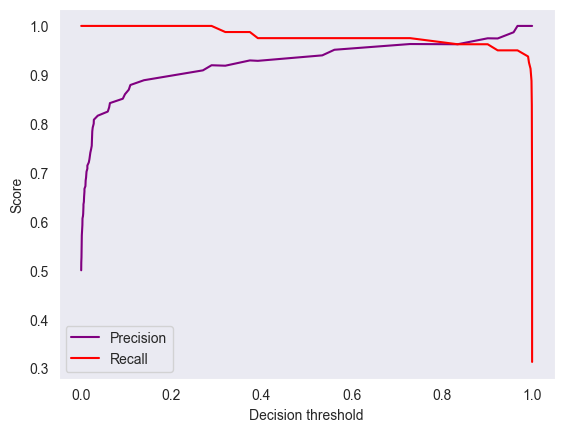

In [92]:
# Calculate probabilities and the Precision-Recall curve

y_pred_proba = lgbm_model.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

plt.plot(thresholds, precision[:-1], label="Precision", color="purple")
plt.plot(thresholds, recall[:-1], label="Recall", color="red")
plt.xlabel("Decision threshold")
plt.ylabel("Score")
plt.legend()
plt.grid()
plt.show()

In [97]:
# Find the threshold that maximizes the F1-score
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6) # 1e-6 avoids division by zero

best_threshold_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_idx]
best_f1 = f1_scores[best_threshold_idx]

print(f"Best threshold : {best_threshold:.3f}")
print(f"Max F1-Score : {best_f1:.3f}")

Best threshold : 0.968
Max F1-Score : 0.974


# Appliquer le nouveau seuil
**Results :**
- Pour les fraudes (précision: 0.91, recall: 0.81, f1-score: 0.85)
- Pour les non fraudes (précision, recall, f1-score : 1)

In [94]:
y_pred_adjusted = (y_pred_proba >= best_threshold).astype(int)

print(classification_report(y_test, y_pred_adjusted))
print(confusion_matrix(y_test, y_pred_adjusted))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98        80
           1       1.00      0.95      0.97        80

    accuracy                           0.97       160
   macro avg       0.98      0.97      0.97       160
weighted avg       0.98      0.97      0.97       160

[[80  0]
 [ 4 76]]


# Save model for API use

In [95]:
import joblib

joblib.dump(lgbm_model, '../src/models/lightgbm_model.pkl')

# Save best threshold
with open('../src/models/best_threshold.txt', 'w') as f:
    f.write(str(best_threshold))
